# **The Impact of News Events On Stock Prices: An NLP Approach**

        Zain Nofal 2021723 

        Muhammad Hamza 2021378

## Step 1: Scraping the news heading

**Objectives**
- 1.1. Selecting the date range for news
- 1.2. Scrape the news headings from the source website

In [1]:
from requests_html import HTMLSession, PyQuery as pq
session = HTMLSession()

from datetime import datetime, timedelta
import json
import numpy as np

### 1.1. Selecting the date range for news

In [6]:
startDate = datetime(2022,1,1)
#endDate = datetime(2022, 1, 9)
endDate = datetime.now().date()
dt = timedelta(days=1)
for i in np.arange(startDate, endDate, dt).astype(datetime):
    print(type(str(i.date())))
    break
#endfor

<class 'str'>


### 1.2. Scrape the news headings from the source website
- Website source used: DAWN News (Most recognized news company in Pakistan)
- Data is saved in JSON format ([headlines.json](./data/news2023/headlines.json))

In [7]:
f = open('/Users/zainnofal/Desktop/MS Project/headlines.json','w', encoding='utf-8')
allData = {}
for i in np.arange(startDate, endDate, dt).astype(datetime):
    while 1:
        temp = f'https://www.dawn.com/latest-news/{str(i.date())}'
        print(temp)
        r = session.get(temp)
        articles = r.html.find('article')
        # print(articles)
        
        if len(articles)>0:
            break
        #endif
            
        print("in while")
    #endwhile
        
    print(f"{str(i.date())} > {len(articles)} articles fetched")
    allData[str(i.date())] = []
    
    for article in articles:
        t = pq(article.html)
        # print(f"{articles.index(article)}: {t}")
        headingText = t('h2.story__title a.story__link').text()
        spanId = t('span').eq(0).attr('id')
        label = spanId.lower() if spanId is not None else None
        # print(f"{label} > {headingText}")
        # print(f"{articles.index(article)}: {headingText}")
        if len(headingText)>0 and label in ["business", "pakistan"]:
            allData[str(i.date())].append({
                "heading": headingText,
                "label": label,
            })
        #endif
    #endfor
#endfor
    
json.dump(allData, f, ensure_ascii=False)
f.close()

https://www.dawn.com/latest-news/2022-01-01
2022-01-01 > 88 articles fetched
https://www.dawn.com/latest-news/2022-01-02
2022-01-02 > 76 articles fetched
https://www.dawn.com/latest-news/2022-01-03
2022-01-03 > 93 articles fetched
https://www.dawn.com/latest-news/2022-01-04
2022-01-04 > 97 articles fetched
https://www.dawn.com/latest-news/2022-01-05
2022-01-05 > 96 articles fetched
https://www.dawn.com/latest-news/2022-01-06
2022-01-06 > 95 articles fetched
https://www.dawn.com/latest-news/2022-01-07
2022-01-07 > 95 articles fetched
https://www.dawn.com/latest-news/2022-01-08
2022-01-08 > 85 articles fetched
https://www.dawn.com/latest-news/2022-01-09
2022-01-09 > 78 articles fetched
https://www.dawn.com/latest-news/2022-01-10
2022-01-10 > 100 articles fetched
https://www.dawn.com/latest-news/2022-01-11
2022-01-11 > 97 articles fetched
https://www.dawn.com/latest-news/2022-01-12
2022-01-12 > 92 articles fetched
https://www.dawn.com/latest-news/2022-01-13
2022-01-13 > 90 articles fetche

## Step 2: Performing sentiment analysis on news headings

**Objectives**
- 2.1. Importing a sentiment model from Huggingface
- 2.2. Writing functions to calculate average sentiment for each day
- 2.3. Getting the news heading and outputting the sentiment score in JSON format

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import json

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.1. Importing a sentiment model from Huggingface

In [9]:
modelName = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(modelName)
model = AutoModelForSequenceClassification.from_pretrained(modelName)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 2.2. Writing functions to calculate average sentiment for each day

In [10]:
def calculateDailySentiment(headlines):
    texts = [headline['heading'] for headline in headlines]
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512, return_attention_mask=True)
    outputs = model(**inputs)
    logits = outputs.logits
    scores = logits.softmax(dim=1)
    averageScore = scores.mean(dim=0).tolist()
    return averageScore
#enddef

def analyzeAndSaveSentiment(inputFile, outputFile):
    with open(inputFile, 'r') as file:
        data = json.load(file)
    #endwith

    result = {}

    for date, headlines in data.items():
        averageScore = calculateDailySentiment(headlines)
        print(f"{date} > {averageScore}")
        result[date] = averageScore
    #endfor

    with open(outputFile, 'w') as outputFile:
        json.dump(result, outputFile, indent=2)
    #endwith
#enddef


### 2.3. Getting the news heading and outputting the sentiment score in JSON format
- Score for each day is saved in the file ([daily_scores.json](./data/news2023/daily_scores.json))

In [12]:
inputJsonFile = 'headlines.json'
outputJsonFile = 'daily_scores.json'

analyzeAndSaveSentiment(inputJsonFile, outputJsonFile)

2022-01-01 > [0.3770291805267334, 0.19091813266277313, 0.1705428957939148, 0.13165323436260223, 0.12985658645629883]
2022-01-02 > [0.3354112505912781, 0.1794319748878479, 0.16584452986717224, 0.1652168482542038, 0.1540953516960144]
2022-01-03 > [0.25235405564308167, 0.16286450624465942, 0.17474520206451416, 0.19691400229930878, 0.21312224864959717]
2022-01-04 > [0.27394697070121765, 0.19102464616298676, 0.18282632529735565, 0.17830079793930054, 0.17390123009681702]
2022-01-05 > [0.28963136672973633, 0.18123097717761993, 0.18452538549900055, 0.17825812101364136, 0.16635416448116302]
2022-01-06 > [0.28418564796447754, 0.17353229224681854, 0.1728244125843048, 0.19521380960941315, 0.17424386739730835]
2022-01-07 > [0.28310009837150574, 0.19257961213588715, 0.17748770117759705, 0.17632101476192474, 0.1705116182565689]
2022-01-08 > [0.30750343203544617, 0.1675490140914917, 0.16634586453437805, 0.18406081199645996, 0.17454083263874054]
2022-01-09 > [0.354084849357605, 0.1814398318529129, 0.17

## Step 3: Preparing data for training

**Objectives**
- 3.1. Importing daily scores from news folder
- 3.2. Importing daily stock data from stock folder
- 3.3. Merge both the imported data with date
- 3.4. Saving the merged data
- 3.5. Check data by plotting the graph

In [13]:
import pandas as pd
import json

import matplotlib.pyplot as plt

### 3.1. Importing daily scores from news folder

In [14]:
with open('daily_scores.json', 'r') as file:
    sentimentScores = json.load(file)
#endwith

dfSentiment = pd.DataFrame(list(sentimentScores.items()), columns=['jsonDate', 'sentiment'])
dfSentiment['date'] = pd.to_datetime(dfSentiment['jsonDate'], format='%Y-%m-%d')
dfSentiment.head()

,jsonDate,sentiment,date
0,2022-01-01,"[0.3770291805267334, 0.19091813266277313, 0.17...",2022-01-01
1,2022-01-02,"[0.3354112505912781, 0.1794319748878479, 0.165...",2022-01-02
2,2022-01-03,"[0.25235405564308167, 0.16286450624465942, 0.1...",2022-01-03
3,2022-01-04,"[0.27394697070121765, 0.19102464616298676, 0.1...",2022-01-04
4,2022-01-05,"[0.28963136672973633, 0.18123097717761993, 0.1...",2022-01-05


### 3.2. Importing daily stock data from stock folder
- Data used will be of Habib Bank Limited (HBL)
- This bank is considered to be the top performing and one of the most profitable bank in the country [[Source: AsiaMoney](https://www.asiamoney.com/article/2bp0xnj0tjyfvvwhd8oow/awards/best-bank-awards/pakistans-best-domestic-bank-2023-hbl)]
- This bank has branches outside Pakistan as well

In [15]:
csvFilePath = 'Download Data - STOCK_PK_XKAR_HBL.csv'
dfCsv = pd.read_csv(csvFilePath)
dfCsv.head()

,Date,Open,High,Low,Close,Volume
0,12/19/2024,161.72,163.10,152.50,154.49,"2,194,124"
1,12/18/2024,167.00,167.10,160.01,161.72,"1,767,041"
2,12/17/2024,158.06,167.10,157.71,163.55,"3,255,283"
3,12/16/2024,162.00,162.75,158.55,159.63,"4,109,609"
4,12/13/2024,169.00,169.40,160.62,162.03,"2,530,295"


### 3.3. Merge both the imported data with date

In [16]:
dfCsv['date'] = pd.to_datetime(dfCsv['Date'], format='%m/%d/%Y')

# Optional: Convert 'Volume' to numeric, removing commas and handling errors
dfCsv['Volume'] = dfCsv['Volume'].replace({',': ''}, regex=True).astype(float)

# Assuming 'dfSentiment' is your sentiment data, merge it with the BBL data on the 'date' column
dfMerged = pd.merge(dfCsv, dfSentiment, on='date', how='left')

# If sentiment column is a list or JSON-like object, split it into individual columns
dfSentimentColumns = pd.DataFrame(dfMerged['sentiment'].tolist(), columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])

# Concatenate sentiment features with the main data
dfMerged = pd.concat([dfMerged, dfSentimentColumns], axis=1)

# Drop unnecessary columns (adjust based on your needs)
dfMerged = dfMerged.drop(columns=['Date', 'sentiment', 'jsonDate'])

# Show the first few rows of the merged DataFrame
dfMerged.head()

,Open,High,Low,Close,Volume,date,feature1,feature2,feature3,feature4,feature5
0,161.72,163.10,152.50,154.49,2194124.0,2024-12-19,0.350502,0.159756,0.153798,0.172509,0.163434
1,167.00,167.10,160.01,161.72,1767041.0,2024-12-18,0.367635,0.193048,0.160913,0.148150,0.130254
2,158.06,167.10,157.71,163.55,3255283.0,2024-12-17,0.290117,0.172380,0.173669,0.182000,0.181833
3,162.00,162.75,158.55,159.63,4109609.0,2024-12-16,0.243373,0.157065,0.162289,0.206459,0.230814
4,169.00,169.40,160.62,162.03,2530295.0,2024-12-13,0.273658,0.161999,0.179834,0.193156,0.191354


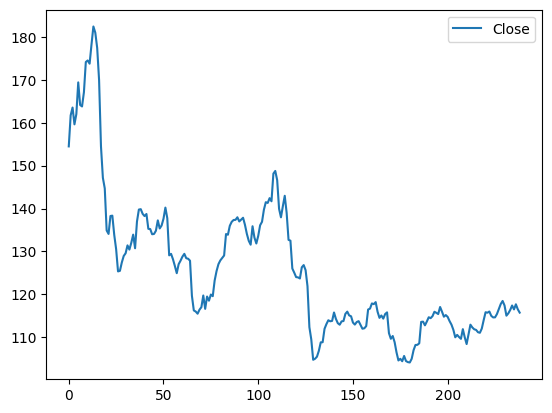

In [17]:
dfMerged[['Close']].plot()
plt.show()

## Step 4: Training on the merged dataset



Objectives

- 4.1. Importing the dataset
- 4.2. Creating a function to preprocess the dataset
- 4.3. Preproccessing the dataset for LSTM
- 4.4. Building the LSTM model
- 4.5. Testing the model

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import regularizers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
def createDataset(dataset, target, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        a = dataset[i:(i + lookBack), :]
        dataX.append(a)
        dataY.append(target[i + lookBack])
    return np.array(dataX), np.array(dataY)
#enddef

In [20]:
features = dfMerged.drop(['date', 'Close'], axis=1).values
target = dfMerged['Close'].values

scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

lookBack = 3
X, y = createDataset(featuresScaled, targetScaled, lookBack)
print(X[:2])
print(y[:2])

trainSize = int(len(X) * 0.8)
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))

[[[0.73575526 0.72816142 0.66220736 0.0419544  0.66238918 0.4125813
   0.22533628 0.44474611 0.39312168]
  [0.80305927 0.77829302 0.76267559 0.0330501  0.73977131 0.86936785
   0.33309703 0.23155837 0.17688896]
  [0.68910134 0.77829302 0.73190635 0.06407862 0.38965553 0.58578921
   0.52631015 0.52781468 0.51302115]]

 [[0.80305927 0.77829302 0.76267559 0.0330501  0.73977131 0.86936785
   0.33309703 0.23155837 0.17688896]
  [0.68910134 0.77829302 0.73190635 0.06407862 0.38965553 0.58578921
   0.52631015 0.52781468 0.51302115]
  [0.73932441 0.72377491 0.74314381 0.08189055 0.1785301  0.37564862
   0.35394558 0.74187593 0.83222372]]]
[[0.70872175]
 [0.73936917]]


In [21]:
batchSize = 1
epoch = 20
neurons = 100
dropout = 0.6

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(units=1, activation='linear', activity_regularizer=regularizers.l1(0.00001)))
model.add(Activation('tanh'))
model.summary()

model.compile(loss='mean_squared_error' , optimizer='RMSprop')

model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 100)         │        44,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,901 (800.39 KB)

 Trainable params: 204,901 (800.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0644 - val_loss: 0.0164
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.0060
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0013
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0043
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0022
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0026
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0030
Epoch 9/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0030
Epoch 10/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 11/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 12/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [22]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictInv = scalerTarget.inverse_transform(trainPredict)
trainYInv = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredictInv = scalerTarget.inverse_transform(testPredict)
testYInv = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [23]:
trainScore = np.sqrt(mean_squared_error(trainYInv[:, 0], trainPredictInv[:, 0]))
print(f'Training RMSE: {trainScore}')
testScore = np.sqrt(mean_squared_error(testYInv[:, 0], testPredictInv[:, 0]))
print(f'Testing RMSE: {testScore}')

trainAccuracy = 100 - (trainScore / np.mean(trainYInv) * 100)
testAccuracy = 100 - (testScore / np.mean(testYInv) * 100)

print(f'Training Accuracy: {trainAccuracy:.2f}%')
print(f'Testing Accuracy: {testAccuracy:.2f}%')

Training RMSE: 4.633896568487231
Testing RMSE: 2.2206820898052975
Training Accuracy: 96.38%
Testing Accuracy: 98.05%


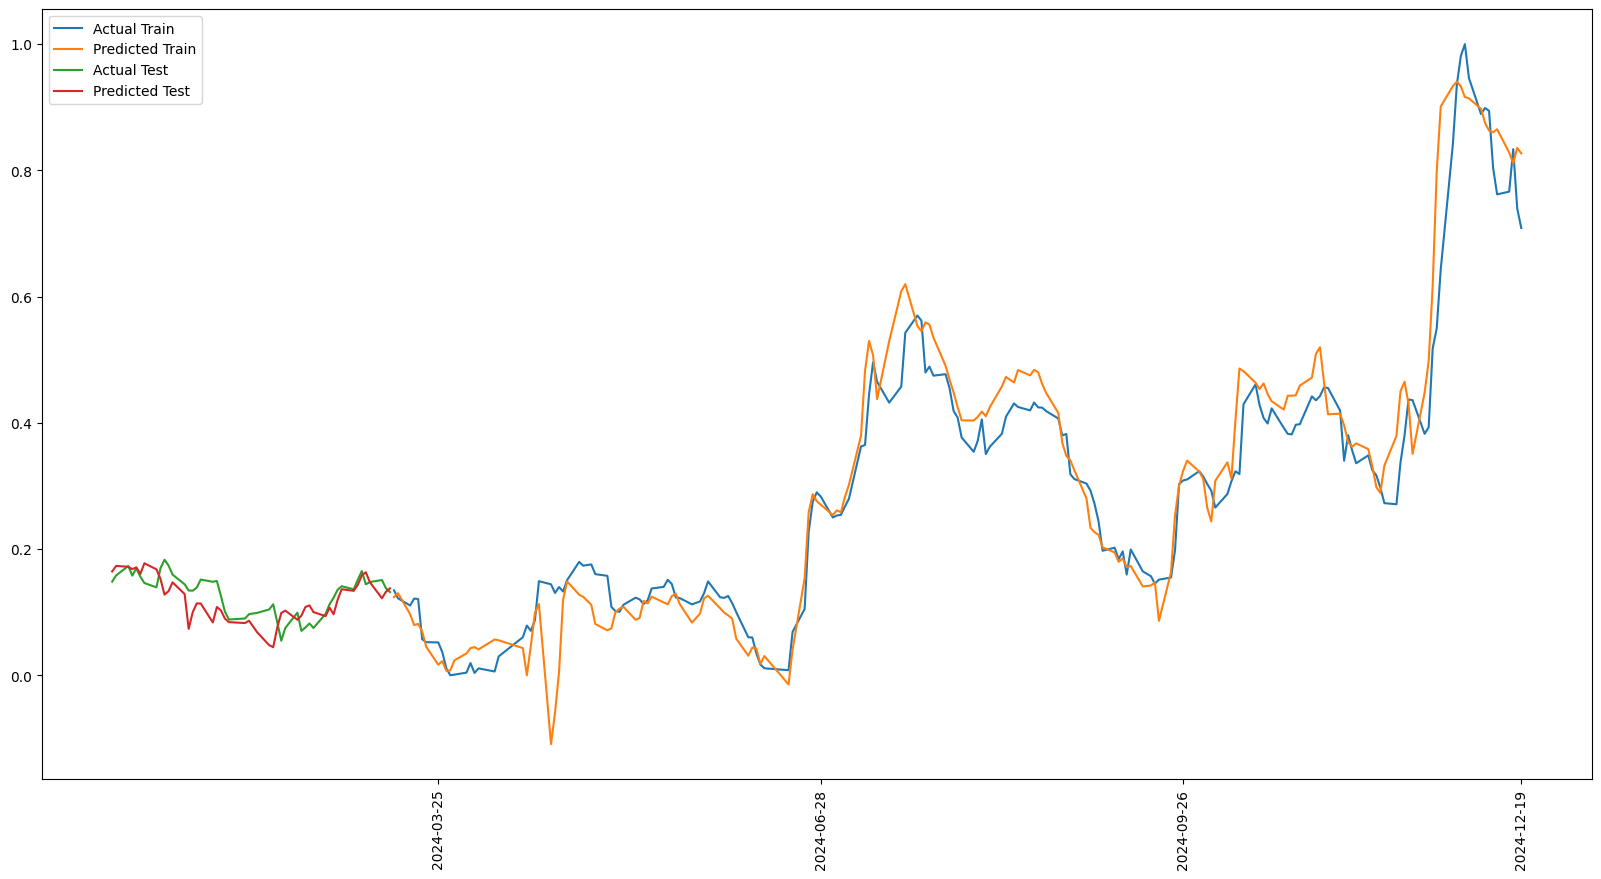

In [24]:
dates = dfMerged['date'].values
sampleInterval = 60
sampledDates = dates[::sampleInterval]

plt.figure(figsize=(20, 10))
plt.plot(dates[:len(trainY)], trainY, label='Actual Train')
plt.plot(dates[:len(trainPredict)], trainPredict, label='Predicted Train')
plt.plot(dates[len(trainY):len(trainY) + len(testY)], testY, label='Actual Test')
plt.plot(dates[len(trainPredict):len(trainPredict) + len(testPredict)], testPredict, label='Predicted Test')

plt.xticks(sampledDates, rotation=90)

plt.legend()
plt.show()

## Engineering Economics

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Simulated future cash flows based on predicted stock prices
def simulate_cash_flows(predicted_prices, initial_investment):
    """ Generate cash inflows (based on predicted stock prices) and assume a final cash outflow for selling the stock at the end. """
    cash_flows = predicted_prices * initial_investment / predicted_prices[0]  # Example: the investment grows with the stock price change
    cash_flows[-1] += initial_investment  # Adding the final cash inflow (selling the stock and getting back the initial investment)
    return cash_flows

### Calculating Net Present Value

In [26]:
# Calculate NPV
def npv(rate, cash_flows):
    """ Calculate Net Present Value """
    return np.sum([cf / (1 + rate) ** i for i, cf in enumerate(cash_flows)])


### Calculating IRR

In [27]:
# Calculate IRR using numerical methods
def calculate_irr(cash_flows):
    """ Find the discount rate that makes NPV equal to zero """
    return fsolve(lambda r: npv(r, cash_flows), 0.1)[0]


NPV: 130429.34
IRR: 1054384.78


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


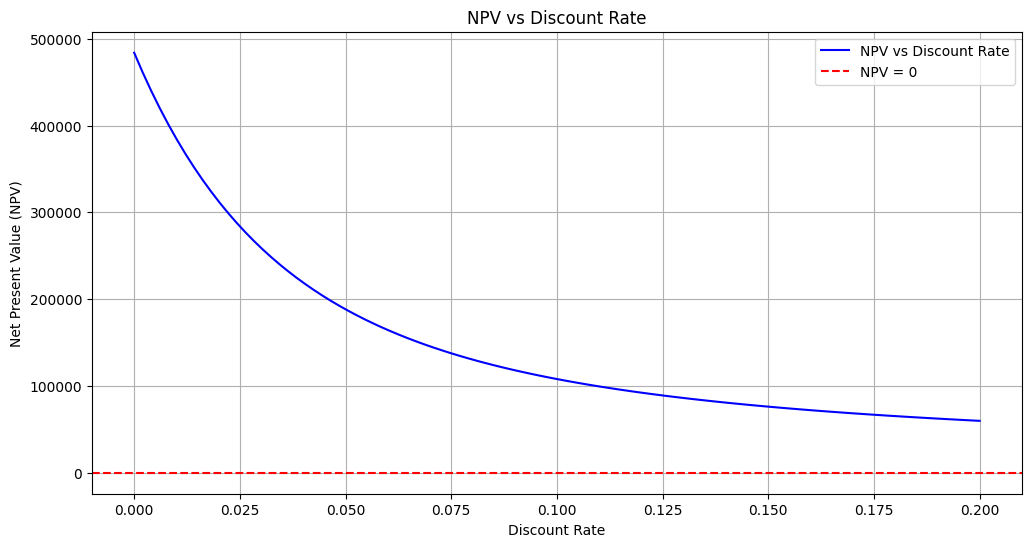

In [28]:
# Simulating cash flows from predicted stock prices
predicted_cash_flows = simulate_cash_flows(testPredictInv.flatten(), initial_investment=10000)

# Assuming a discount rate (e.g., 8% annually)
discount_rate = 0.08

# Calculating NPV
npv_value = npv(discount_rate, predicted_cash_flows)
print(f"NPV: {npv_value:.2f}")

# Calculating IRR
irr_value = calculate_irr(predicted_cash_flows)
print(f"IRR: {irr_value:.2f}")

# Visualizing the NPV vs Discount Rate
discount_rates = np.linspace(0, 0.2, 100)
npvs = [npv(rate, predicted_cash_flows) for rate in discount_rates]

plt.figure(figsize=(12, 6))
plt.plot(discount_rates, npvs, label="NPV vs Discount Rate", color='blue')
plt.axhline(0, color='red', linestyle='--', label="NPV = 0")
plt.xlabel('Discount Rate')
plt.ylabel('Net Present Value (NPV)')
plt.title('NPV vs Discount Rate')
plt.legend()
plt.grid(True)
plt.show()

Simulating Cash Flows:
In the simulate_cash_flows function, we're assuming that the predicted stock prices can be used as an indicator of the future value of the investment. We simulate cash inflows based on the predicted stock prices and assume a final cash inflow when selling the stock at the end of the period.
Net Present Value (NPV):
The npv function calculates the present value of future cash flows, discounted by a given rate. In this case, we are using a typical discount rate of 8% for the calculations, but you can adjust it based on your project's context or financial assumptions.
Internal Rate of Return (IRR):
The calculate_irr function uses fsolve to find the discount rate that makes the NPV equal to zero. This is the IRR that tells you the return on investment considering the future stock prices.
Visualizations:
NPV vs Discount Rate: This plot shows how the NPV changes as the discount rate varies. The red dashed line represents the point where NPV = 0, which is the IRR.
Predicted vs Actual Stock Prices: This visualization compares the predicted stock prices from the model against the actual values, helping you assess the model's performance.
Predicted Cash Flows: This plot shows the predicted cash inflows based on the stock price predictions.

How This Relates to Engineering Economics:
By using NPV and IRR, you're evaluating the financial feasibility of the stock investment, which directly applies to Engineering Economics concepts, especially for investment decision-making.
NPV helps assess the profitability of the investment, while IRR shows the expected return on investment. These are important tools for deciding whether to proceed with an investment based on predicted stock prices.

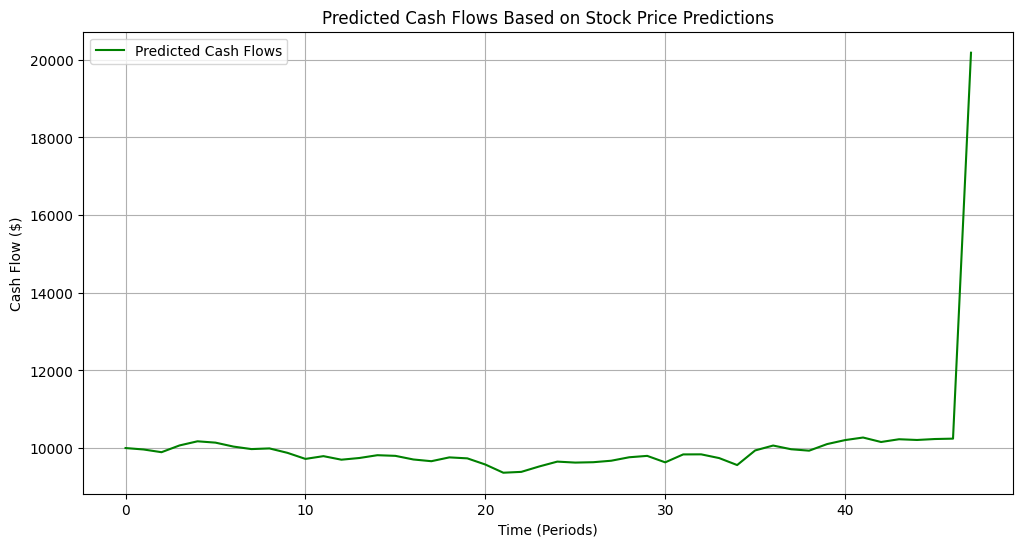

In [29]:
# Visualizing Cash Flows
plt.figure(figsize=(12, 6))
plt.plot(predicted_cash_flows, label="Predicted Cash Flows", color='green')
plt.xlabel('Time (Periods)')
plt.ylabel('Cash Flow ($)')
plt.title('Predicted Cash Flows Based on Stock Price Predictions')
plt.legend()
plt.grid(True)
plt.show()

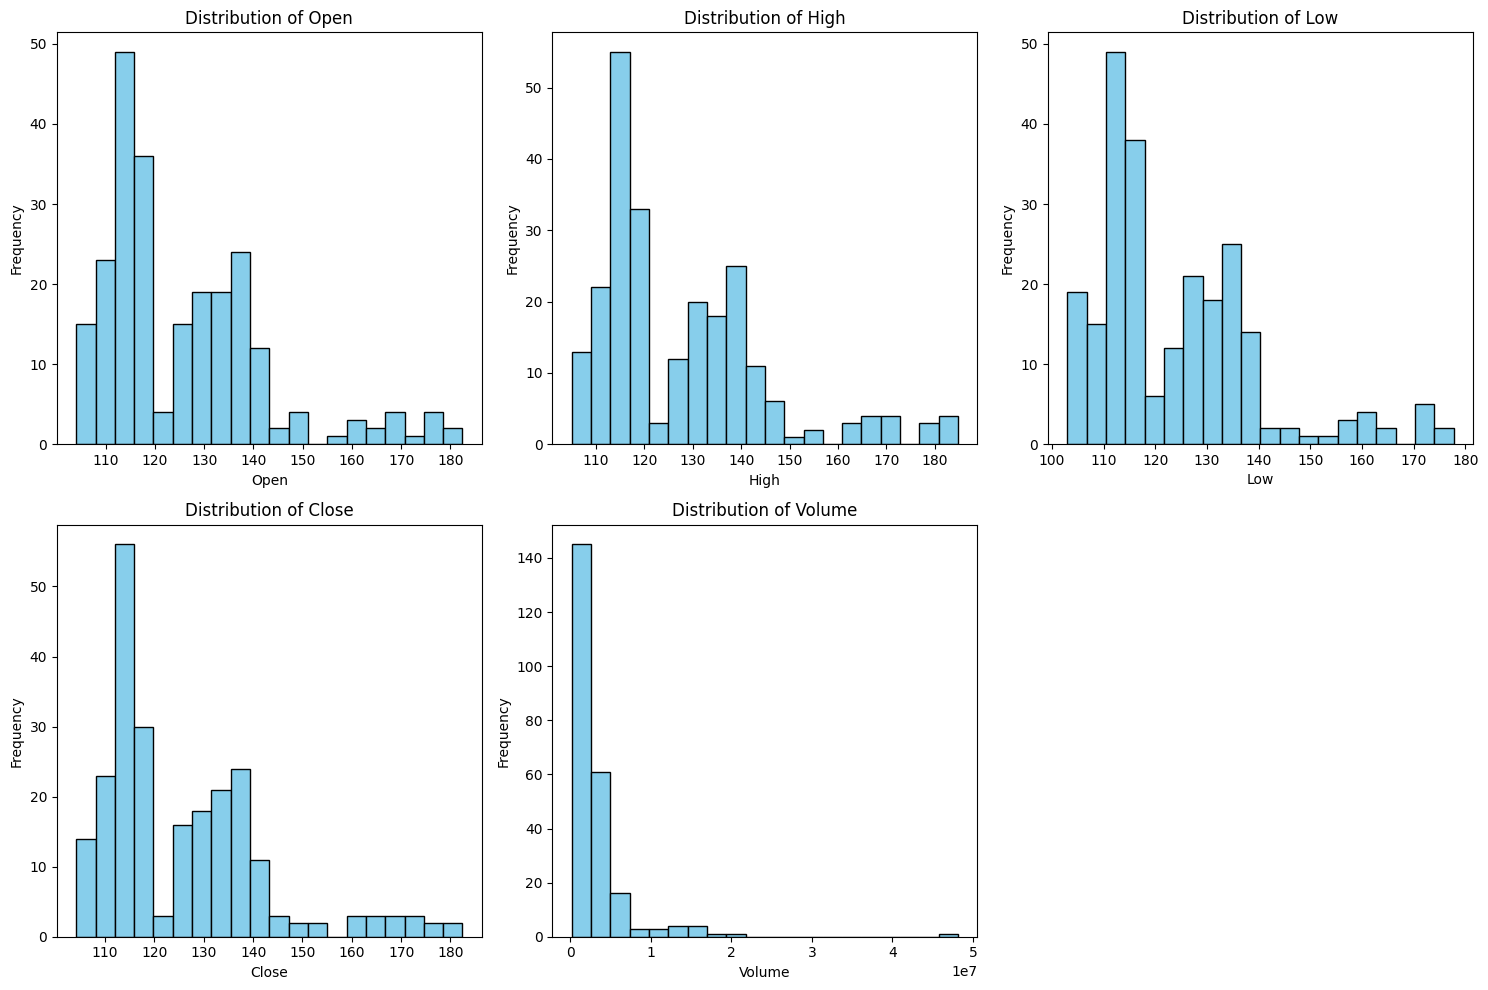

In [30]:
# Plotting histograms for numerical features
features_to_plot = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    plt.hist(dfMerged[feature], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


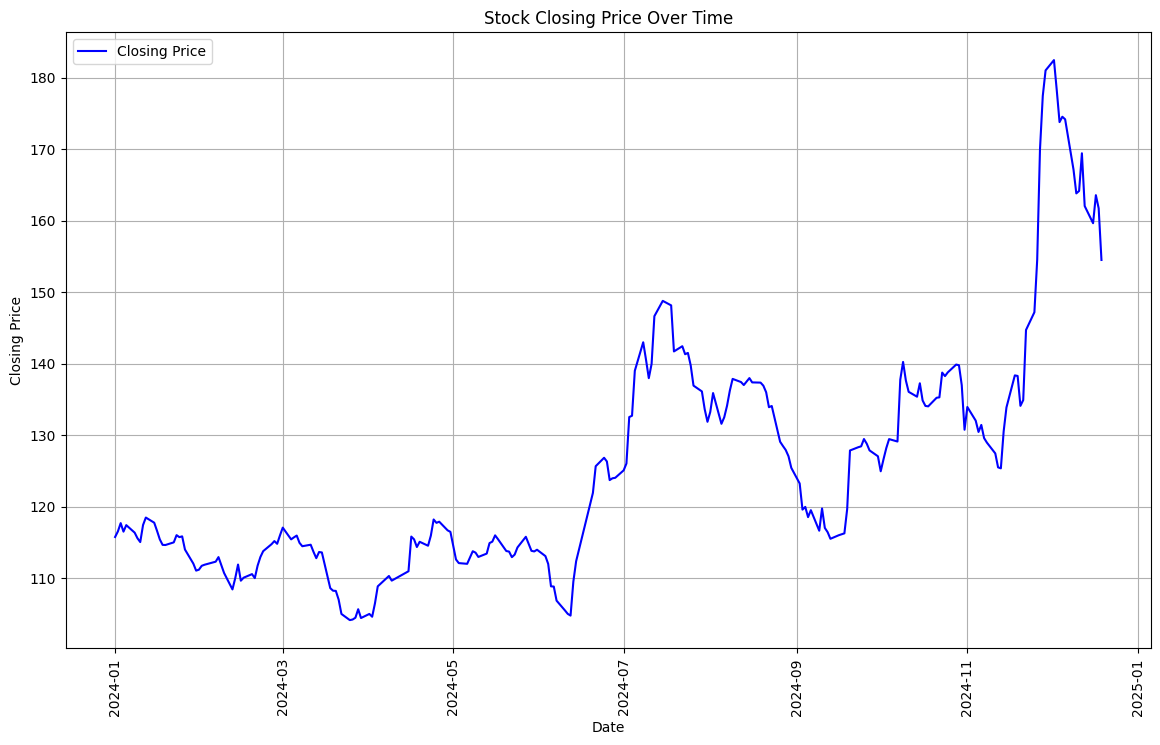

In [31]:
# Plotting Close Price over time
plt.figure(figsize=(14, 8))
plt.plot(dfMerged['date'], dfMerged['Close'], label='Closing Price', color='b')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Closing Price Over Time')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()


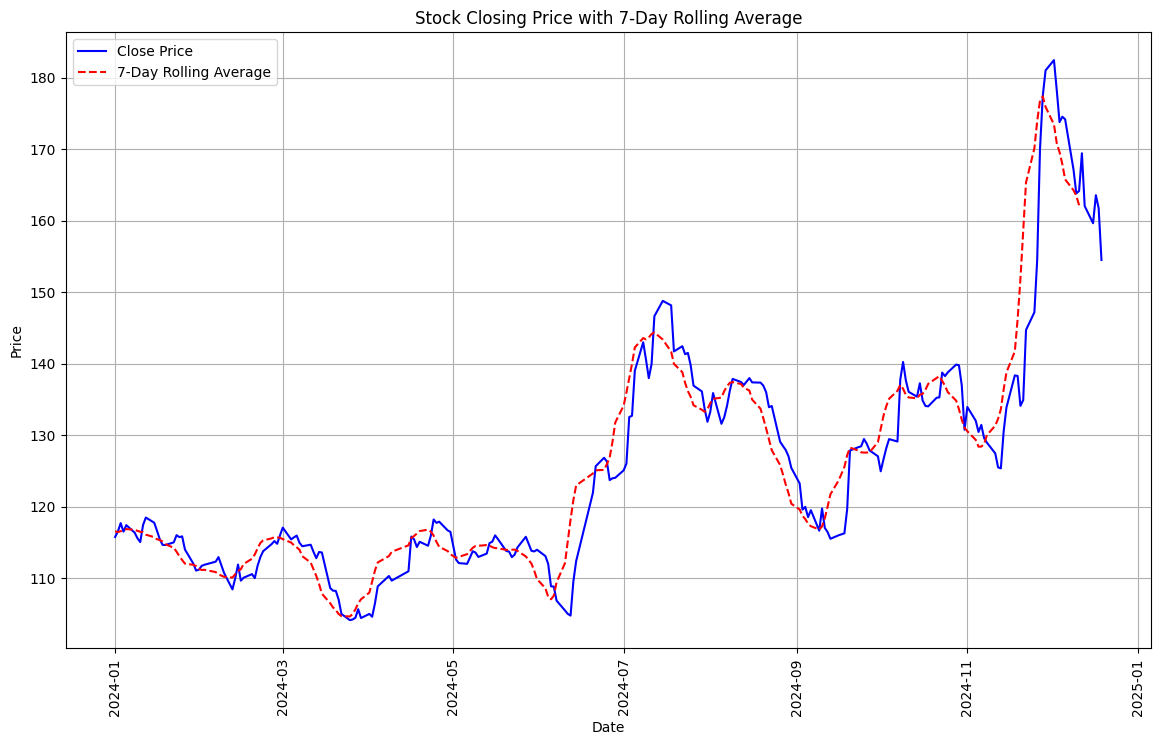

In [32]:
# Rolling average (7-day) of closing prices
dfMerged['Close_7d_avg'] = dfMerged['Close'].rolling(window=7).mean()

plt.figure(figsize=(14, 8))
plt.plot(dfMerged['date'], dfMerged['Close'], label='Close Price', color='blue')
plt.plot(dfMerged['date'], dfMerged['Close_7d_avg'], label='7-Day Rolling Average', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Closing Price with 7-Day Rolling Average')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()


In [33]:
data=dfMerged

<Figure size 1000x600 with 0 Axes>

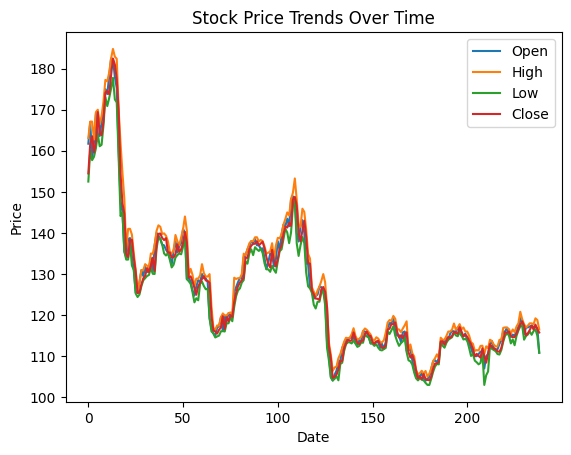

In [34]:
# Plotting market trends over time
plt.figure(figsize=(10, 6))
data[['Open', 'High', 'Low', 'Close']].plot(title="Stock Price Trends Over Time")
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()



In [39]:
# Renaming the columns to sentiment labels
data = data.rename(columns={
    'feature1': 'very_negative',
    'feature2': 'negative',
    'feature3': 'neutral',
    'feature4': 'positive',
    'feature5': 'very_positive'
})


<Figure size 1000x600 with 0 Axes>

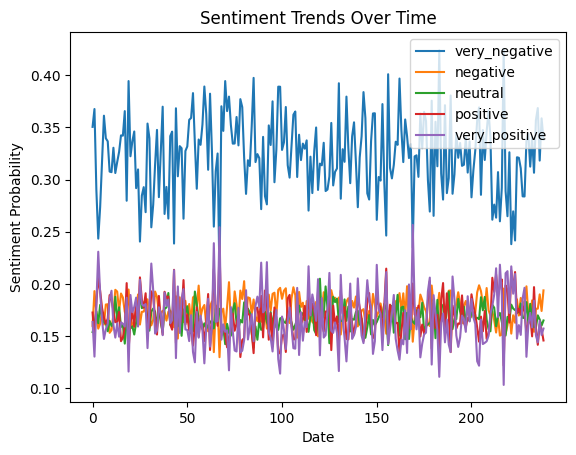

In [40]:
# Plotting sentiment trends over time
plt.figure(figsize=(10, 6))
data[['very_negative', 'negative', 'neutral', 'positive', 'very_positive']].plot(title="Sentiment Trends Over Time")
plt.ylabel("Sentiment Probability")
plt.xlabel("Date")
plt.show()

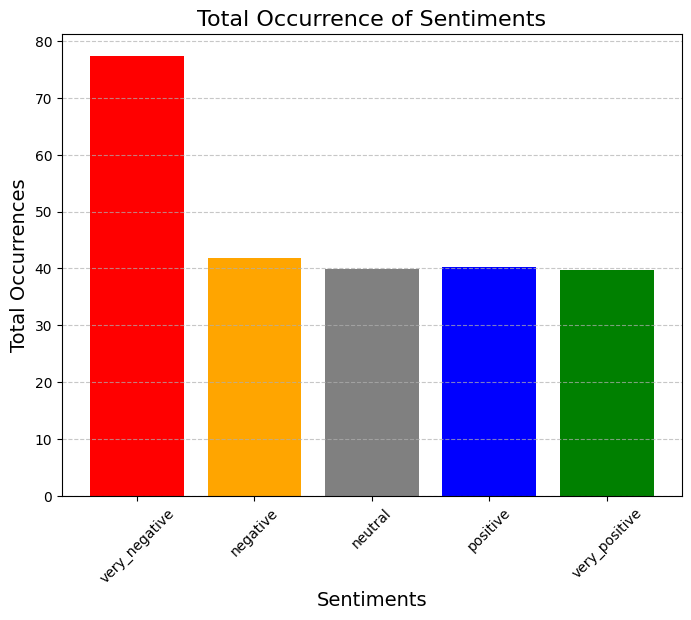

In [42]:
import matplotlib.pyplot as plt

# Summing occurrences for each sentiment
sentiment_totals = {
    'very_negative': data['very_negative'].sum(),
    'negative': data['negative'].sum(),
    'neutral': data['neutral'].sum(),
    'positive': data['positive'].sum(),
    'very_positive': data['very_positive'].sum()
}

# Bar chart for sentiment occurrences
plt.figure(figsize=(8, 6))
plt.bar(sentiment_totals.keys(), sentiment_totals.values(), color=['red', 'orange', 'gray', 'blue', 'green'])

# Adding labels and title
plt.title("Total Occurrence of Sentiments", fontsize=16)
plt.xlabel("Sentiments", fontsize=14)
plt.ylabel("Total Occurrences", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [43]:
data

,Open,High,Low,Close,Volume,date,very_negative,negative,neutral,positive,very_positive,Close_7d_avg
0,161.72,163.10,152.50,154.49,2194124.0,2024-12-19,0.350502,0.159756,0.153798,0.172509,0.163434,NaN
1,167.00,167.10,160.01,161.72,1767041.0,2024-12-18,0.367635,0.193048,0.160913,0.148150,0.130254,NaN
2,158.06,167.10,157.71,163.55,3255283.0,2024-12-17,0.290117,0.172380,0.173669,0.182000,0.181833,NaN
3,162.00,162.75,158.55,159.63,4109609.0,2024-12-16,0.243373,0.157065,0.162289,0.206459,0.230814,NaN
4,169.00,169.40,160.62,162.03,2530295.0,2024-12-13,0.273658,0.161999,0.179834,0.193156,0.191354,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
234,117.45,117.99,115.20,117.41,1060265.0,2024-01-05,0.356999,0.176113,0.158283,0.157778,0.150827,116.861429
235,117.10,117.75,116.10,116.50,1132175.0,2024-01-04,0.368535,0.176186,0.169799,0.141592,0.143888,116.682857
236,117.01,119.21,116.49,117.69,3264531.0,2024-01-03,0.318193,0.189887,0.165873,0.161503,0.164544,116.571429
237,116.89,118.80,115.00,116.53,4163065.0,2024-01-02,0.358694,0.174003,0.160041,0.156320,0.150943,116.444286


In [45]:
import pandas as pd

# Load your data into a DataFrame
# Assuming the data is already in a DataFrame named `data`

# Identify the sentiment with the highest probability
data['highest_sentiment'] = data[['very_negative', 'negative', 'neutral', 'positive', 'very_positive']].idxmax(axis=1)
data

,Open,High,Low,Close,Volume,date,very_negative,negative,neutral,positive,very_positive,Close_7d_avg,highest_sentiment
0,161.72,163.10,152.50,154.49,2194124.0,2024-12-19,0.350502,0.159756,0.153798,0.172509,0.163434,NaN,very_negative
1,167.00,167.10,160.01,161.72,1767041.0,2024-12-18,0.367635,0.193048,0.160913,0.148150,0.130254,NaN,very_negative
2,158.06,167.10,157.71,163.55,3255283.0,2024-12-17,0.290117,0.172380,0.173669,0.182000,0.181833,NaN,very_negative
3,162.00,162.75,158.55,159.63,4109609.0,2024-12-16,0.243373,0.157065,0.162289,0.206459,0.230814,NaN,very_negative
4,169.00,169.40,160.62,162.03,2530295.0,2024-12-13,0.273658,0.161999,0.179834,0.193156,0.191354,NaN,very_negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,117.45,117.99,115.20,117.41,1060265.0,2024-01-05,0.356999,0.176113,0.158283,0.157778,0.150827,116.861429,very_negative
235,117.10,117.75,116.10,116.50,1132175.0,2024-01-04,0.368535,0.176186,0.169799,0.141592,0.143888,116.682857,very_negative
236,117.01,119.21,116.49,117.69,3264531.0,2024-01-03,0.318193,0.189887,0.165873,0.161503,0.164544,116.571429,very_negative
237,116.89,118.80,115.00,116.53,4163065.0,2024-01-02,0.358694,0.174003,0.160041,0.156320,0.150943,116.444286,very_negative


In [46]:
# Drop the specified columns
columns_to_drop = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive', 'Close_7d_avg']
data = data.drop(columns=columns_to_drop)

# Display the updated DataFrame
print(data.head())


     Open    High     Low   Close     Volume       date highest_sentiment
0  161.72  163.10  152.50  154.49  2194124.0 2024-12-19     very_negative
1  167.00  167.10  160.01  161.72  1767041.0 2024-12-18     very_negative
2  158.06  167.10  157.71  163.55  3255283.0 2024-12-17     very_negative
3  162.00  162.75  158.55  159.63  4109609.0 2024-12-16     very_negative
4  169.00  169.40  160.62  162.03  2530295.0 2024-12-13     very_negative


highest_sentiment
very_negative    237
very_positive      2
Name: count, dtype: int64


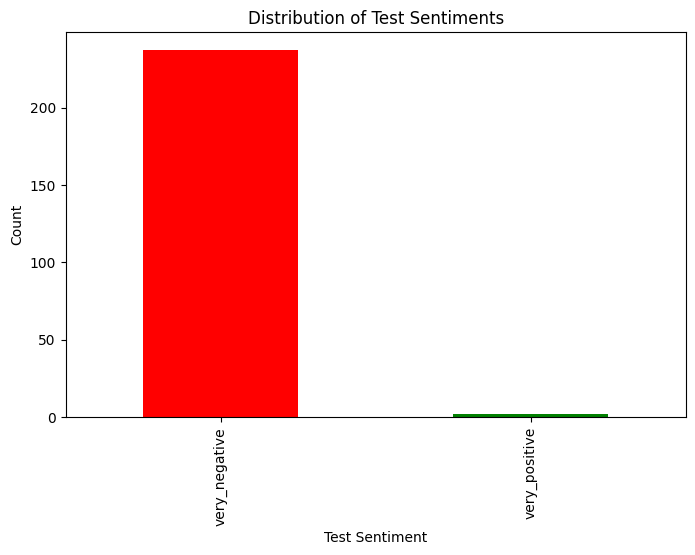

In [50]:
# Count occurrences of each sentiment
sentiment_counts = data['highest_sentiment'].value_counts()
print(sentiment_counts)

# Bar chart of sentiment distribution
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Distribution of Test Sentiments')
plt.ylabel('Count')
plt.xlabel('Test Sentiment')
plt.show()

In [51]:
# Summary statistics grouped by test_sentiment
grouped_stats = data.groupby('highest_sentiment').mean()
print(grouped_stats)


                         Open        High         Low       Close  \
highest_sentiment                                                   
very_negative      125.757257  127.707215  123.919283  125.780633   
very_positive      113.190000  113.975000  111.770000  113.480000   

                         Volume                          date  
highest_sentiment                                              
very_negative      3.181165e+06 2024-06-27 10:25:49.367088640  
very_positive      8.788985e+05 2024-07-01 00:00:00.000000000  


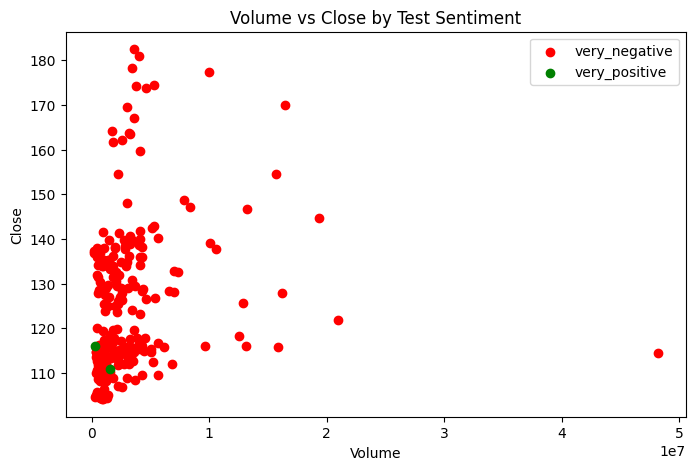

In [53]:
# Scatter plot to analyze relationship between Volume and Close by test_sentiment
colors = {'very_negative': 'red', 'very_positive': 'green'}
plt.figure(figsize=(8, 5))
for sentiment in data['highest_sentiment'].unique():
    subset = data[data['highest_sentiment'] == sentiment]
    plt.scatter(subset['Volume'], subset['Close'], label=sentiment, color=colors[sentiment])
    
plt.title('Volume vs Close by Test Sentiment')
plt.xlabel('Volume')
plt.ylabel('Close')
plt.legend()
plt.show()
